In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
import helpers.data_mining_helpers as dmh
files = ["amazon_cells_labelled.txt", "imdb_labelled.txt", "yelp_labelled.txt"]
categories_name = ["amazon","imdb","yelp"]
data = []

#clean datas and make them to lists(text,label)
for i in range(3):
    with open("sentiment labelled sentences/"+files[i]) as the_file:
        while True:
            line = the_file.readline()
            if not line: break
            line = line.strip("\n")
            label = int(line[-1])
            text = line.rstrip("\t 0").rstrip("\t 1")
            data.append([text,categories_name[i],label])
random.shuffle(data)

# construct dataframe from a list
X = pd.DataFrame(np.array(data), columns= ["text","category_name","label"])
X['category'] = X.category_name.apply(lambda t: categories_name.index(t))
X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))
mlb = preprocessing.LabelBinarizer()
mlb.fit(X.category_name)
X['bin_category'] = mlb.transform(X['category_name']).tolist()

In [2]:
X

,text,category_name,label,category,unigrams,bin_category
0,This is not movie-making.,imdb,0,1,"[This, is, not, movie-making, .]","[0, 1, 0]"
1,"Worst service to boot, but that is the least o...",yelp,0,2,"[Worst, service, to, boot, ,, but, that, is, t...","[0, 0, 1]"
2,I like the fact that it rests lightly against ...,amazon,1,0,"[I, like, the, fact, that, it, rests, lightly,...","[1, 0, 0]"
3,Anne Heche was utterly convincing.,imdb,1,1,"[Anne, Heche, was, utterly, convincing, .]","[0, 1, 0]"
4,"And, FINALLY, after all that, we get to an end...",imdb,0,1,"[And, ,, FINALLY, ,, after, all, that, ,, we, ...","[0, 1, 0]"
...,...,...,...,...,...,...
2995,"Gotta love those close-ups of slimy, drooling ...",imdb,1,1,"[Got, ta, love, those, close-ups, of, slimy, ,...","[0, 1, 0]"
2996,Would recommend this item.,amazon,1,0,"[Would, recommend, this, item, .]","[1, 0, 0]"
2997,The update procedure is difficult and cumbersome.,amazon,0,0,"[The, update, procedure, is, difficult, and, c...","[1, 0, 0]"
2998,This is a really fantastic Thai restaurant whi...,yelp,1,2,"[This, is, a, really, fantastic, Thai, restaur...","[0, 0, 1]"


## new data visualizations

In [3]:
from collections import Counter
negative_word = ["no","not","n't","bad","worse"]
negative_num = []

#count the negative word all documents have and append it to X as a column
for i in range(len(X)):
    lower_unigram = [x.lower() for x in X.loc[i,"unigrams"]]
    count = 0
    counter = dict(Counter(word for word in lower_unigram))
    for neg in negative_word:
        if neg in lower_unigram: 
            count += counter[neg]
    negative_num.append(count)
X['negative_num'] = negative_num

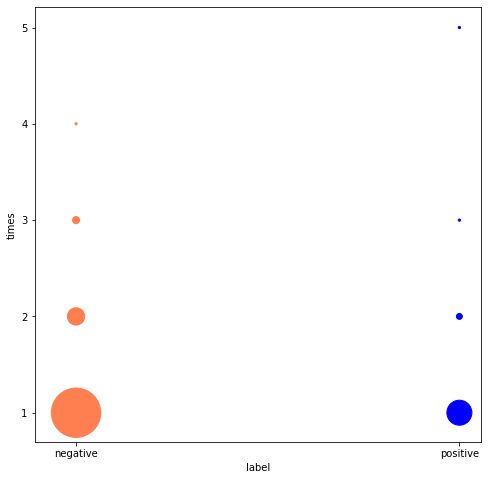

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['0','1']
col = ['coral', 'blue']
index = [0,1]
base_angle = 30
negative_num = np.array(negative_num)

fig = plt.figure(figsize = (8,8))

#draw a scatter picture
ax = fig.subplots()
for c, label in zip(col, labels):
    ys = negative_num[X['label'] == label]
    counter = dict(Counter(num for num in list(ys)))
    all_num = sum(counter.values())
    s = []
    ys = []
    
    # calculate the sie of s
    for key in counter.keys():
        if key == 0: continue
        s.append(float(counter[key]))  
        ys.append(key)
    s = np.array(s)
    s*=5
    label_x = np.array([index[int(label)] for i in range(len(s))])
    ax.scatter(label_x, ys, c = c, s = s, marker='o')
ax.set_ylabel('times')
ax.set_xlabel('label')
plt.xticks(index, ['negative','positive'])
    

plt.show()

Y label(times) means the times of negative words(EX: no,not,n't,bad,worse), and the size of circles means the number of the text. For example (negative,1) is largest, so there're most text labeld negative with one negative word.

The figure shows: There're more negative words in the texts labeld negative, because in the same times, almost all circles (excpet for times five) of negative are bigger than those of positive.

## TF-IDF features

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X.loc[:,'text'])
print(tfidf.shape)

(3000, 5155)


## Naive Bayes classifier

In [6]:
## preprocess
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text)

X_train, X_test, Y_train, Y_test = train_test_split(np.append(tfidf.toarray(), X_counts.toarray(), 1), X['label'], test_size=0.25)

In [7]:
## tfidf
clf = MultinomialNB()
clf.fit(X_train[:,:tfidf.shape[1]], Y_train)
clf.score(X_test[:,:tfidf.shape[1]], Y_test)

0.8386666666666667

In [8]:
## word frequency
clf = MultinomialNB()
clf.fit(X_train[:,tfidf.shape[1]:], Y_train)
clf.score(X_test[:,tfidf.shape[1]:], Y_test)

0.8426666666666667

Becasue the datas are split randomly, and it will influence the result. Hence, I ran the code ten times for both tfidf and word frequency. In the end, I averaged the results ten times, and found word frequency is a little better than tfidf.